In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import zipfile
import os

zip_file_dogs = '/content/drive/MyDrive/dataset/all-dogs.zip'
zip_file_annotations = '/content/drive/MyDrive/dataset/Annotation.zip'

destination_dogs = '/content/all-dogs.zip'
destination_annotations = '/content/Annotation.zip'

shutil.copy(zip_file_dogs, destination_dogs)
shutil.copy(zip_file_annotations, destination_annotations)

def extract_zip(file_path, extract_to):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

os.makedirs('/content/all-dogs', exist_ok=True)
os.makedirs('/content/annotations', exist_ok=True)

extract_zip(destination_dogs, '/content/all-dogs')
extract_zip(destination_annotations, '/content/annotations')

print("Extraction complete.")

Extraction complete.


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = datasets.ImageFolder('/content/all-dogs', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. img_channels x 64 x 64
        )

    def forward(self, input):
        return self.gen(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input is img_channels x 64 x 64
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.disc(input).view(-1, 1).squeeze(1)


In [ ]:
import torch

batch_size = 32
latent_vector_size = 100

generator = Generator()
discriminator = Discriminator()

generator.load_state_dict(torch.load('/content/drive/MyDrive/gan_checkpoint/netG.pth', map_location=torch.device('cpu') ))
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/gan_checkpoint/netD.pth', map_location=torch.device('cpu') ))

generator.eval()
discriminator.eval()

adversarial_loss = nn.BCELoss()

z = torch.randn(batch_size, 100, 1, 1)
fake_images = generator(z)

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

real_images, _ = next(iter(train_loader))
real_labels = torch.ones(batch_size, 1)
real_predictions = discriminator(real_images)
d_loss_real = adversarial_loss(real_predictions.view(-1), real_labels.view(-1))
real_accuracy = (real_predictions > 0.5).float().mean()

fake_labels = torch.zeros(batch_size, 1)
fake_predictions = discriminator(fake_images.detach())
d_loss_fake = adversarial_loss(fake_predictions.view(-1), fake_labels.view(-1))
fake_accuracy = (fake_predictions < 0.5).float().mean()

d_loss = (d_loss_real + d_loss_fake) / 2
d_accuracy = (real_accuracy + fake_accuracy) / 2

g_loss = adversarial_loss(discriminator(fake_images).view(-1), real_labels.view(-1))

# Print losses and accuracies
print(f"Generator Loss: {g_loss.item()}")
print(f"Discriminator Loss: {d_loss.item()}")
print(f"Discriminator Real Accuracy: {real_accuracy.item()}")
print(f"Discriminator Fake Accuracy: {fake_accuracy.item()}")



Generator Loss: 0.54738450050354
Discriminator Loss: 0.9648611545562744
Discriminator Real Accuracy: 0.96875
Discriminator Fake Accuracy: 0.3125


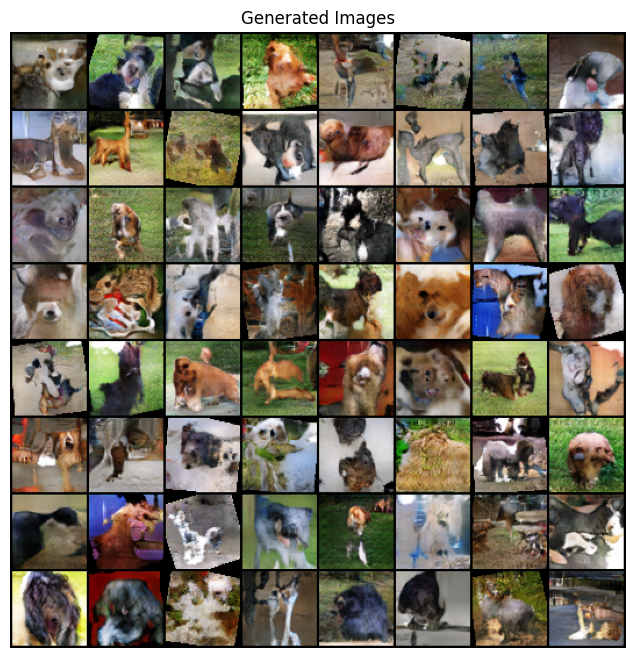

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_generated_images(generator, num_images=64, z_dim=100):
    # Generate batch of latent vectors
    noise = torch.randn(num_images, z_dim, 1, 1)

    # Generate fake image batch with G
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()

    # Plot the fake images
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(vutils.make_grid(fake_images, padding=2, normalize=True).permute(1, 2, 0))
    plt.show()

# Example of using the function
show_generated_images(generator)


In [ ]:
generator.push_to_hub()

AttributeError: 'Generator' object has no attribute 'push_to_hub'